In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [2]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-div_abun_sizechl_sds/data?format=csv'
result = pd.read_csv(fileURL)
print(result.columns)

Index([u'abundance', u'size', u'N0', u'H', u'J', u'T', u'S', u'LON', u'LAT', u'day', u'Cruise', u'file'], dtype='object')


In [3]:
# calculate density
result['density'] = sw.rho(result['S'].values,result['T'].values,0)
# subset the data into big and small

big = result[(result['size']=='big')]
small = result[(result['size']=='small')]

value = 'H'
xb = (big['LON']).values # longitude
yb = (big['LAT']).values # latitude
zb = (big[value]).values # bead attribute

xs = (small['LON']).values # longitude
ys = (small['LAT']).values # latitude
zs = (small[value]).values # bead attribute

# convert all longitude to longitude east
xb[xb<0]= 360+xb[xb<0];
xs[xs<0]= 360+xs[xs<0];

xbew = xb
xsew = xs
xbew[xbew>180] = xbew[xbew>180]-360
xsew[xsew>180] = xsew[xsew>180]-360

print(np.max(result['density'].values))

1050.56915251


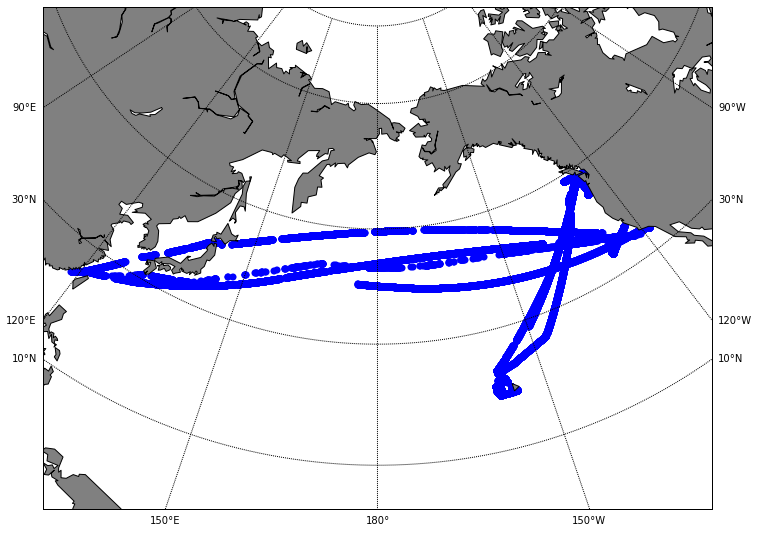

In [4]:
fig1 = plt.figure(1, figsize=(15,9))

m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=60,lat_0=45,lon_0=-180.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(xbew,yb)
#m.scatter(xm, ym, s=75, c=(big['density'].values-1000), alpha=.5,lw=0,vmin=20, vmax=30)
m.scatter(xm, ym, s=50, lw=0)

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

#cb = plt.colorbar(shrink=.92)
#cb.set_label(label='sigma_t' ,fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.show()

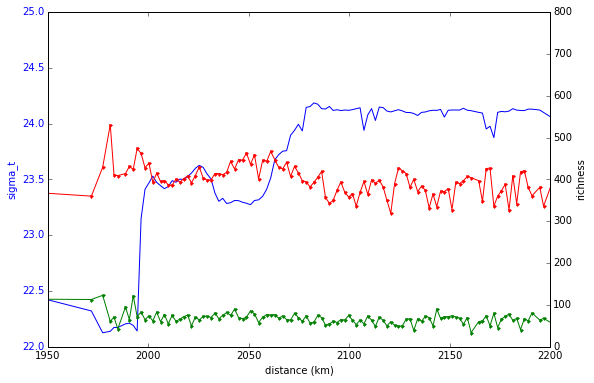

In [8]:
# select a specific cruise and look at diversity vs density
cr = 'Tokyo_1'
subset = small[(small['Cruise']==cr)].sort(['day','file'],ascending=[1,1])
bsubset = big[(big['Cruise']==cr)].sort(['day','file'],ascending=[1,1])
tt = subset['T']
#tt[tt<10]=np.nan


xx = (subset['LON']).values # longitude
yy = (subset['LAT']).values # latitude

# convert all longitude to longitude east
xx[xx<0]= 360+xx[xx<0];
xbew = xx
xbew[xbew>180] = xbew[xbew>180]-360

# calculate distance between points
distance = sw.distance(xbew,yy, 0)[0]
track = np.cumsum(distance)
track = np.insert(track, 0, 0)

fig2, ax1 = plt.subplots(figsize=(9,6))
ax1.plot(track/1000, subset['density']-1000,'b-')
ax1.set_xlabel('distance (km)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('sigma_t', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.ylim(22,25)
ax2 = ax1.twinx()
ax2.plot(track/1000, subset['N0'], 'r.-',track/1000,bsubset['N0'],'g.-')
ax2.set_ylabel('richness', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.xlim(1950,2200)
plt.show()

In [6]:
#print subset['day']

In [7]:
# load in the underway data for Tokyo_1 to fill in the gaps
inputdata = '/Users/sclayton/Documents/seaflow/data/tokyo_underway/Tokyo_underway_chl1.csv'
data = pd.read_csv(inputdata)
x = (data['long.dc']).values # longitude
y = (data['lat.dc']).values # latitude

# convert all longitude to longitude east
x[x<0]= 360+x[x<0];
xew = x
xew[xew>180] = xew[xew>180]-360

# need to line up the underway data and the seaflow data, so find the offset between the first entries in each list
# underway first entry
uu = [xew[0],y[0]]
ss = [xbew[0], yy[0]]
# distance between ss and uu
uwoffset = sw.distance([ss[0],uu[0]],[ss[1],uu[1]],0)

# calculate along track distance 
distanceuw = sw.distance(xew,y,0)[0]
trackuw = np.cumsum(distanceuw)+uwoffset
trackuw = np.insert(trackuw, 0, uwoffset)

# calculate density
T = data['T1'].values
S = data['S'].values
D = sw.rho(S,T,0)
C = data['chl'].values

fig3, ax1 = plt.subplots(figsize=(15,9))
ax1.plot(trackuw/1000, T,'b.')
ax1.set_xlabel('distance (km)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('sigma_t', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(track/1000, subset['N0'], 'r.')
ax2.set_ylabel('N0', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
#plt.xlim(3000,4000)
plt.show()


IOError: File /Users/sclayton/Documents/seaflow/data/tokyo_underway/Tokyo_underway_chl1.csv does not exist